In [1]:
# Data should be in format
# index,enerygy,tempF
# 2012-01-01 00:00:00+00:00,30.2197,49.9725
# load the data as data=pd.read_csv('data.csv', index_col=0, parse_dates=True)
# 

# Follow lines do notthing
#from eemeter.modeling.models import caltrack
#model = CaltrackDailyModel(fit_cdd = True, grid_search = True)
#output = model.fit(mydata)
%matplotlib inline

import matplotlib

In [188]:
import json
site_to_zip_code = {}
with open('/vagrant/etl-natgrid-lime/test_data_hourly/maps/site_list.json') as fd:
    jsd = json.load(fd)
    dt = jsd['data']
    for dct in dt:
        site_id, zipcode = dct['site_id'], dct['s_postcode']
        site_to_zip_code[str(site_id)] = zipcode


# Loading the NATGrid hourly data
# 
import json
import numpy as np
import pytz
import pandas 
import os
from eemeter.weather.location import zipcode_to_usaf_station
from eemeter.weather import ISDWeatherSource
from datetime import datetime

#file_name = '/vagrant/etl-natgrid-lime/test_data_hourly/raw_site_data/2017-07-27/28610.json'
file_name = '/vagrant/etl-natgrid-lime/test_data_hourly/raw_site_data/2017-07-27/28162.json'

format='%Y-%m-%d %H:%M:%S'

def prepare_hrl_data_md(fl):
    with open(fl) as fp:
        js_data = json.load(fp)
    
    dt = js_data['data']
    #print "Keys in the Json data ",js_data.keys()
    result = []
    index = []
    energy_consumed= []
    day_hrs = []
    week_day = []
    for energy_data in dt:
        # energy_cs can have none values
        energy_cs = energy_data['energy_consumed']
        if energy_cs is None:
            continue
        tt = float(energy_cs)
        if not np.isfinite(tt):
            print  energy_cs
        #print energy_cs
        time_st = energy_data['t_stamp']
        pd_dt_tm = pandas.to_datetime(time_st, format=format, utc=True)
        day_hrs.append(str( pd_dt_tm.hour))
        week_day.append(str(pd_dt_tm.dayofweek))
        index.append(pd_dt_tm)
        energy_consumed.append(energy_cs)
        
    dt_index = pandas.DatetimeIndex(index, tz=pytz.utc)
    df = pandas.DataFrame({'energy' : np.array(energy_consumed, dtype=np.float16),
                           'hour' : day_hrs,
                           'weekday' : week_day
                          }, 
                          
                          index=dt_index)
    df = df[~df.index.duplicated(keep='first')].sort_index()
    df = df.asfreq('H')
    return df

def get_model_df(file_name):
    rs = prepare_hrl_data_md(file_name)
    fname = os.path.basename(file_name)[:-5]
    zipcode = site_to_zip_code[fname]
    usaf = zipcode_to_usaf_station(zipcode)
    weather_source = ISDWeatherSource(usaf)
    tt = weather_source.indexed_temperatures(rs.index, "degF")
    rs = rs.assign(tempF=tt.values)
    return rs

rs = get_model_df( '/vagrant/etl-natgrid-lime/test_data_hourly/raw_site_data/2017-07-27/28162.json')
rs = rs[np.isfinite(rs['energy'])]

from eemeter.modeling.models.caltrack_hourly import CaltrackHourlyModel
model = CaltrackHourlyModel(fit_cdd = True, grid_search = True)
model.fit(rs)


{'cvrmse': 0.36698796078363921,
 'model_params': {'X_design_info': DesignInfo(['Intercept', 'CDD_65'],
             factor_infos={EvalFactor('CDD_65'): FactorInfo(factor=EvalFactor('CDD_65'),
                                      type='numerical',
                                      state=<factor state>,
                                      num_columns=1)},
             term_codings=OrderedDict([(Term([]),
                                        [SubtermInfo(factors=(),
                                                     contrast_matrices={},
                                                     num_columns=1)]),
                                       (Term([EvalFactor('CDD_65')]),
                                        [SubtermInfo(factors=(EvalFactor('CDD_65'),),
                                                     contrast_matrices={},
                                                     num_columns=1)])])),
  'cdd_bp': 65,
  'coefficients': {'CDD_65': 174.92445744888445,
   'In

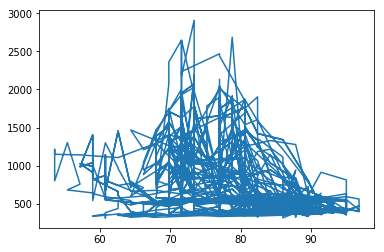

In [59]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(rs['temp'], rs['energy'])
#rs.hist()
#correlations = rs.corr()
#ax = fig.add_subplot(111)
#cax = ax.matshow(correlations, vmin=-1, vmax=1)
# plot correlation matrix
#fig = plt.figure()
#plt.show()


In [161]:
from scipy.stats import linregress
import statsmodels.api as sm
import numpy as np 
import patsy
import statsmodels.formula.api as smf
formulae = 'energy ~ tempF +  hour + weekday + hour:weekday'
rs = rs[np.isfinite(rs['energy'])]
model = smf.ols(formula=formulae, data=rs)
res = model.fit()
y, X = patsy.dmatrices(
                formulae, rs, return_type='dataframe')

rmse = np.sqrt(res.ssr/res.nobs)

print res.params['Intercept'],  res.rsquared_adj,  "RMSE :", np.sqrt(res.ssr/res.nobs)

548.59329139 0.929640760437 RMSE : 673.647315918


In [162]:
# Model with absoulute temperature
from scipy.stats import linregress
import statsmodels.api as sm
import numpy as np 
import patsy
import math
import statsmodels.formula.api as smf
formulae = 'energy ~  absTempF +  hour + weekday + hour:weekday'
absT = abs(rs['tempF'] - 65)
ts = rs.assign(absTempF = absT)
ts = ts[np.isfinite(ts['energy'])]
model = smf.ols(formula=formulae, data=ts)
res = model.fit()
y, X = patsy.dmatrices(
                formulae, ts, return_type='dataframe')
rmse = np.sqrt(res.ssr/res.nobs)

print res.params['Intercept'],  res.rsquared_adj,  "RMSE :", rmse
predicted = res.predict(ts)
#print ts

4607.03432125 0.914263784438 RMSE : 743.62532208


In [41]:

from eemeter.modeling.models.caltrack_hourly import CaltrackHourlyModel
#print rs[100:200]
model = CaltrackHourlyModel(fit_cdd = True, grid_search = False)
model.fit(rs)




{'cvrmse': 0.57929394284569513,
 'model_params': {'X_design_info': DesignInfo(['Intercept', 'HDD_60'],
             factor_infos={EvalFactor('HDD_60'): FactorInfo(factor=EvalFactor('HDD_60'),
                                      type='numerical',
                                      state=<factor state>,
                                      num_columns=1)},
             term_codings=OrderedDict([(Term([]),
                                        [SubtermInfo(factors=(),
                                                     contrast_matrices={},
                                                     num_columns=1)]),
                                       (Term([EvalFactor('HDD_60')]),
                                        [SubtermInfo(factors=(EvalFactor('HDD_60'),),
                                                     contrast_matrices={},
                                                     num_columns=1)])])),
  'cdd_bp': None,
  'coefficients': {'HDD_60': 63.359027868531115,
   '

In [119]:




from eemeter.weather import ISDWeatherSource
import pandas as pd
import pytz
daily_index = pd.date_range('2017-07-27', periods=24, freq='H', tz=pytz.UTC)
usaf = zipcode_to_usaf_station('14738')
print usaf
weather_source = ISDWeatherSource(usaf)
print ws.indexed_temperatures(daily_index, "degF")


1203
2 3


In [126]:
print rs

                           energy hour weekday  tempF
2017-06-07 10:00:00+00:00  1454.0   10       2   48.2
2017-06-07 11:00:00+00:00  2902.0   11       2   48.2
2017-06-07 12:00:00+00:00  3244.0   12       2   48.2
2017-06-07 13:00:00+00:00  2088.0   13       2   48.2
2017-06-07 14:00:00+00:00     NaN  NaN     NaN   51.8
2017-06-07 15:00:00+00:00     NaN  NaN     NaN   51.8
2017-06-07 16:00:00+00:00  1233.0   16       2   53.6
2017-06-07 17:00:00+00:00  1344.0   17       2   57.2
2017-06-07 18:00:00+00:00   650.5   18       2   60.8
2017-06-07 19:00:00+00:00   793.0   19       2   60.8
2017-06-07 20:00:00+00:00   132.5   20       2   62.6
2017-06-07 21:00:00+00:00     NaN  NaN     NaN   64.4
2017-06-07 22:00:00+00:00     NaN  NaN     NaN   62.6
2017-06-07 23:00:00+00:00     NaN  NaN     NaN   62.6
2017-06-08 00:00:00+00:00     NaN  NaN     NaN   60.8
2017-06-08 01:00:00+00:00     NaN  NaN     NaN   57.2
2017-06-08 02:00:00+00:00     NaN  NaN     NaN   55.4
2017-06-08 03:00:00+00:00   

In [146]:
181/1357.0

0.13338246131171702

In [165]:
import pandas as pd
print pd.get_dummies(rs)

                            energy  tempF  hour_0  hour_1  hour_10  hour_11  \
2017-06-01 00:00:00+00:00   4360.0  66.92       1       0        0        0   
2017-06-01 01:00:00+00:00   3062.0  66.02       0       1        0        0   
2017-06-01 02:00:00+00:00   3434.0  64.94       0       0        0        0   
2017-06-01 03:00:00+00:00   4340.0  62.96       0       0        0        0   
2017-06-01 04:00:00+00:00   3826.0  60.98       0       0        0        0   
2017-06-01 05:00:00+00:00   3258.0  59.00       0       0        0        0   
2017-06-01 06:00:00+00:00   3880.0  57.92       0       0        0        0   
2017-06-01 07:00:00+00:00   3190.0  57.92       0       0        0        0   
2017-06-01 08:00:00+00:00   4640.0  59.00       0       0        0        0   
2017-06-01 09:00:00+00:00   2952.0  55.94       0       0        0        0   
2017-06-01 10:00:00+00:00   9944.0  55.94       0       0        1        0   
2017-06-01 11:00:00+00:00   9560.0  57.92       0   

In [186]:
from sklearn.linear_model import ElasticNetCV    
import pandas as pd
from sklearn.metrics import mean_squared_error
import math
l1_ratio = [.1, 0.2, 0.3, 0.4, .5, .6, .7, .8, .9, .95, .99, 1]
rs_dummies = pd.get_dummies(rs)
#print rs_dummies
cross_validation = 20
ecv = ElasticNetCV(l1_ratio=l1_ratio, cv=cross_validation)
Y = rs_dummies['energy']

X = rs_dummies.drop('energy', axis=1)
model = ecv.fit(X, Y)
pd = model.predict(X)
math.sqrt(mean_squared_error(Y, pd))



1113.6418759064263